In [54]:
import pandas as pd
# import pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader
train_start = 420
train_end = 500+train_start
def prepare_data():
    """
    Function to download stock data and prepare the dataset
    """

    # read data from stockData.csv which has date, Stock1, Stock2, Stock3, Stock4, Stock5 etc
    # we will use this data to create a dataset
    portfolio = pd.read_csv('stockData.csv')
    asset_list = portfolio.columns[1:]
    
    portfolio = portfolio.iloc[train_start:train_end]
    num_days = train_end - train_start + 1
    # drop first column
    portfolio = portfolio.drop(portfolio.columns[0], axis=1)

    # print(portfolio)

    
    # Calculate daily returns
    daily_returns = portfolio.pct_change().dropna()
    
    # Prepare inputs and targets for the model
    inputs = torch.tensor(daily_returns.values[:-1], dtype=torch.float32)  # Using returns as inputs
    targets = torch.tensor(daily_returns.values[1:], dtype=torch.float32)  # Predicting next day's returns
    
    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    return data_loader, daily_returns, asset_list

data_loader, daily_returns,asset_list = prepare_data()
# print the shape of daily_returns
print(daily_returns)
print(daily_returns.shape)

     ADANIPORTS  ASIANPAINT  AXISBANK      HDFC       ITC       TCS        LT  \
421    0.013252    0.001897 -0.000554 -0.017869  0.005320 -0.018490 -0.001602   
422    0.010349   -0.009467 -0.012644  0.028392 -0.007837 -0.036063 -0.014348   
423   -0.020873   -0.013120 -0.020602 -0.014911 -0.029286  0.023694 -0.007886   
424   -0.019491   -0.028618  0.006686  0.000731 -0.022162  0.007664 -0.014826   
425    0.045310    0.008844  0.021886 -0.003733 -0.000401  0.003337  0.017524   
..          ...         ...       ...       ...       ...       ...       ...   
915    0.008558   -0.019170  0.000558  0.004464  0.007074  0.000596  0.003545   
916    0.000106    0.016243  0.036902 -0.002632 -0.004896  0.003446 -0.006417   
917    0.011758   -0.010630  0.019162 -0.001161 -0.012620  0.022775 -0.003438   
918   -0.022617   -0.004981  0.000190  0.005615 -0.017201  0.008093 -0.000772   
919   -0.015415   -0.020245 -0.010286 -0.013165  0.002292 -0.000510 -0.007016   

     HINDUNILVR      INFY  

In [55]:
def loss_function(predictions, targets, lambda_reg=0.5, diversification_reg=0.1):
    """
    Loss function: Mean return - lambda_reg * portfolio variance + diversification_reg * diversification penalty
    """
    
    portfolio_return = torch.mean(torch.sum(predictions * targets, dim=1))
    portfolio_variance = torch.var(torch.sum(predictions * targets, dim=1))
    
    # New term to encourage diversification
    diversification_penalty = diversification_reg * torch.var(predictions)
    total_loss = -portfolio_return + lambda_reg * portfolio_variance + diversification_penalty
    
    return total_loss

In [56]:
# nn
import torch.nn as nn
class Portfolio(nn.Module):
    """
    This class defines a simple Portfolio model using PyTorch.
    :param input_size: Number of input features
    :param output_size: Number of output features
    """
    def __init__(self, input_size, output_size):
        super(Portfolio, self).__init__()
        # Define a simple MLP architecture
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.Softmax(dim=-1)  # Use Softmax to ensure allocations sum up to 1
        )

    def forward(self, x):
        return self.network(x)

In [57]:
def train_network(model, data_loader, optimizer, epochs=1000):
    """
    Train the model using the given data_loader and optimizer
    :param model: The model to train
    :param data_loader: DataLoader for the training data
    :param optimizer: Optimizer to use for training
    :param epochs: Number of epochs to train
    
    :return: None
    """
    model.train()
    count=0
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            if epoch==0:
                count+=1
            predictions = model(inputs)
            loss = loss_function(predictions, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    print(count)
    
    weights = model(next(iter(data_loader))[0])
    # Normalize the weights to ensure they sum up to 1 for each sample
    normalized_weights = torch.nn.functional.normalize(weights, p=1, dim=-1)
    # Compute the mean allocation across all samples
    mean_allocation = torch.mean(normalized_weights, dim=0)
    return mean_allocation
        

In [58]:
# set input size as the size of inputs in data_loader
input_size = next(iter(data_loader))[0].shape[1]
output_size = daily_returns.shape[1]
print(input_size, output_size)
model = Portfolio(input_size=input_size, output_size=output_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

weights=train_network(model, data_loader, optimizer)

15 15
Epoch 0, Loss: 0.00015487494238186628
Epoch 1, Loss: 0.0025453201960772276


Epoch 2, Loss: 0.0019250379409641027
Epoch 3, Loss: -0.0015433084918186069
Epoch 4, Loss: -0.0016855235444381833
Epoch 5, Loss: 0.0034314750228077173
Epoch 6, Loss: 0.0006078685401007533
Epoch 7, Loss: 0.0007380780880339444
Epoch 8, Loss: 0.0005595814436674118
Epoch 9, Loss: 0.0011962816352024674
Epoch 10, Loss: 0.0011120594572275877
Epoch 11, Loss: 0.003217012155801058
Epoch 12, Loss: 0.0057218438014388084
Epoch 13, Loss: 0.002227307064458728
Epoch 14, Loss: -0.004348618909716606
Epoch 15, Loss: -0.0008508871542289853
Epoch 16, Loss: 0.00053068483248353
Epoch 17, Loss: 0.0004617274971678853
Epoch 18, Loss: 0.001462815678678453
Epoch 19, Loss: -0.00033733525197021663
Epoch 20, Loss: 0.003492026124149561
Epoch 21, Loss: 0.001847954117693007
Epoch 22, Loss: 0.0012737270444631577
Epoch 23, Loss: 0.001037954119965434
Epoch 24, Loss: 0.002908586524426937
Epoch 25, Loss: 0.0009020702564157546
Epoch 26, Loss: 0.003769745584577322
Epoch 27, Loss: 0.0037388517521321774
Epoch 28, Loss: 0.0027657

In [59]:
# print the asset_list with corresponding weights rounded to 2 decimal places
for i in range(len(asset_list)):
    print(f'{asset_list[i]}: {weights[i].item():.2f}')


ADANIPORTS: 0.10
ASIANPAINT: 0.14
AXISBANK: 0.12
HDFC: 0.04
ITC: 0.06
TCS: 0.08
LT: 0.06
HINDUNILVR: 0.10
INFY: 0.07
ICICIBANK: 0.05
RELIANCE: 0.00
KOTAKBANK: 0.06
HEROMOTOCO: 0.08
WIPRO: 0.05
HCLTECH: 0.00


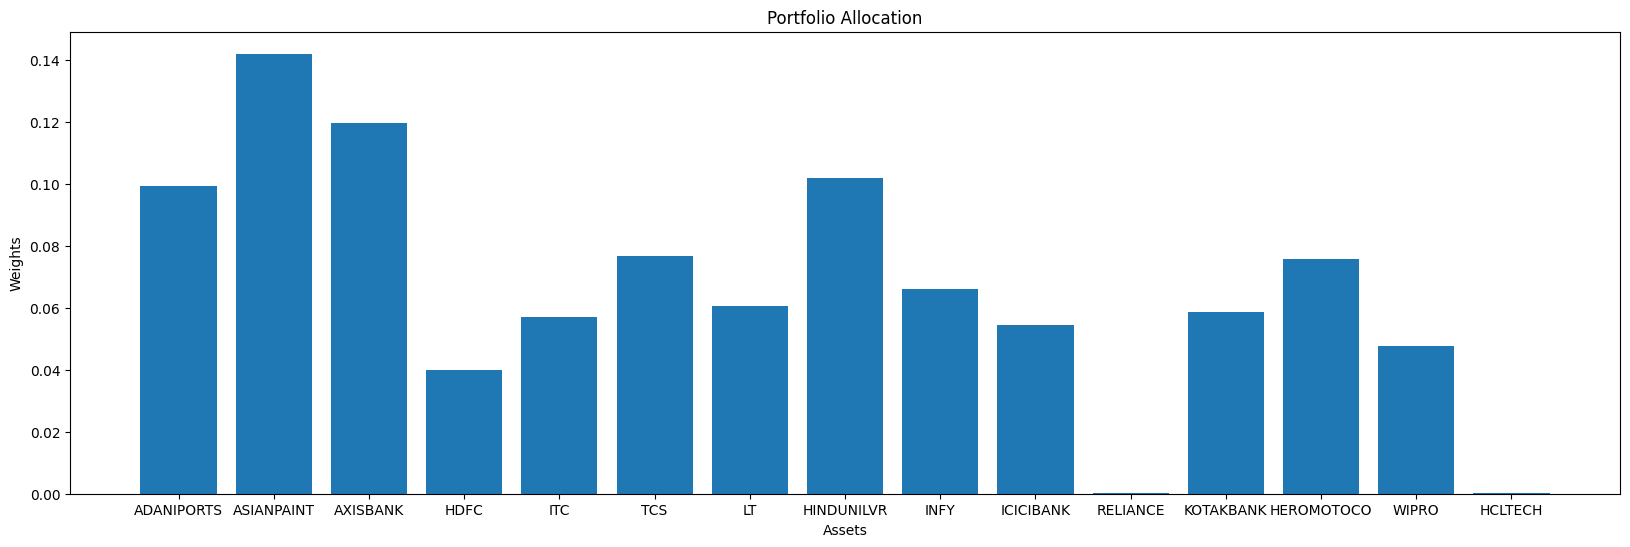

In [60]:
# make a bar plot of the asset_list with corresponding weights
import matplotlib.pyplot as plt
# make the size of the plot bigger
plt.figure(figsize=(20, 6))
plt.bar(asset_list, weights.detach().numpy())
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Portfolio Allocation')
plt.show()


In [63]:
# now testing this portfolio
import numpy as np
testing_period=60
risk_free_rate = 0.075
portfolio = pd.read_csv('stockData.csv')
portfolio_test = portfolio.iloc[train_end:train_end+testing_period]
portfolio_test = portfolio_test.drop(portfolio_test.columns[0], axis=1)
daily_returns_test = portfolio_test.pct_change().dropna()
cov_matrix = daily_returns.cov()
# convert weights to numpy array
# check if weights are in numpy array or not
if isinstance(weights, torch.Tensor):
    weights = weights.detach().numpy()
portfolio_return = np.sum(daily_returns_test.mean() * weights) * testing_period
portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(testing_period)
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
print("Portfolio return: ",portfolio_return)
print("Portfolio risk(std dev): ",portfolio_std_dev)
print("Sharpe ratio: ",sharpe_ratio)
# print(f'({portfolio_return:.2f}, {portfolio_std_dev:.2f}, {sharpe_ratio:.2f}')

Portfolio return:  0.13704150761852285
Portfolio risk(std dev):  0.07425475218853117
Sharpe ratio:  0.8355223846280012
